In [ ]:
import os
import random
import jieba
import re
import time
import chardet
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora, models
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from collections import defaultdict

In [3]:
class ReadFile:
    def __init__(self, root_dir, stop_words_path):
        self.root_dir = root_dir
        self.stop_words_path = stop_words_path

    def get_corpus(self):
        with open(self.stop_words_path, 'r', encoding='utf-8') as stop_words_file:
            stop_words = [line.strip() for line in stop_words_file.readlines()]

        text_dict = {}

        r1 = '[a-zA-Z0-9’!"#$%&\'()*+,-./:：;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
        listdir = os.listdir(self.root_dir)

        for file_name in listdir:
            path = os.path.join(self.root_dir, file_name)
            if os.path.isfile(path) and file_name.split('.')[-1] == 'txt' and file_name != 'inf.txt':
                # 自动检测文件编码
                with open(os.path.abspath(path), 'rb') as raw_file:
                    raw_data = raw_file.read()
                    encoding = chardet.detect(raw_data)['encoding']
                    # 如果检测置信度太低，默认使用gb18030
                    if encoding is None or chardet.detect(raw_data)['confidence'] < 0.7:
                        encoding = 'gb18030'
                
                try:
                    # 使用检测到的编码读取文件
                    with open(os.path.abspath(path), "r", encoding=encoding) as file:
                        file_content = file.read()
                except UnicodeDecodeError:
                    # 如果检测编码失败，尝试用gb18030
                    try:
                        with open(os.path.abspath(path), "r", encoding='gb18030') as file:
                            file_content = file.read()
                    except:
                        print(f"无法解码文件: {file_name}")
                        continue

                file_content = file_content. \
                    replace("本书来自www.cr173.com免费txt小说下载站", '')
                file_content = file_content. \
                    replace("更多更新免费电子书请关注www.cr173.com", '')
                file_content = re.sub(r1, '', file_content)
                file_content = file_content.replace("\n", '')
                file_content = file_content.replace(" ", '')
                file_content = file_content.replace('\u3000', '')


                new_words_lst = []
                split_words = list(jieba.cut(file_content))
                for word in split_words:
                    if word not in stop_words:
                        new_words_lst.append(word)

                print(file_name.split('.')[0], '总词数：', len(new_words_lst))
                
                text_dict[file_name.split('.')[0]] = new_words_lst

            elif os.path.isdir(path):
                print('文件路径不存在!!!!!!')
        return text_dict

In [4]:
read_file = ReadFile(root_dir="./jyxstxtqj_downcc.com", stop_words_path='./停词表.txt')
text_dict = read_file.get_corpus()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/qt/q3cd3b7j0w3238k0qw9k66540000gn/T/jieba.cache
Loading model cost 0.195 seconds.
Prefix dict has been built successfully.


侠客行 总词数： 118939
射雕英雄传 总词数： 305633
鹿鼎记 总词数： 400667
越女剑 总词数： 5708
雪山飞狐 总词数： 45289
连城诀 总词数： 75150
飞狐外传 总词数： 148579
神雕侠侣 总词数： 326467
天龙八部 总词数： 402786
鸳鸯刀 总词数： 11848
三十三剑客图 总词数： 22188
碧血剑 总词数： 164947
白马啸西风 总词数： 11848
笑傲江湖 总词数： 321130
倚天屠龙记 总词数： 324676
书剑恩仇录 总词数： 174686


In [ ]:

def main(text_dict, paragraph_num=62, paragraph_length=500, num_topics=10, 
         use_character=False, random_consistent=True, random_seed=0):
    
    # 将元素为词的列表转化为字
    if use_character:
        for label, text in text_dict.items():
            text_dict[label] = list(''.join(text))
    
    # 从每篇文章中抽取一定长度一定数量的段落
    text_lst = []
    label_lst = []
    for label, text in text_dict.items():
        for i in range(0, paragraph_num):
            label_lst.append(label)
            if random_consistent:
                random.seed(random_seed)
            random_int = random.randint(0, len(text)-paragraph_length-1)
            text_lst.append(text[random_int:random_int+paragraph_length])
    
    # 标签编码
    label_dict = {}
    for label in label_lst:
        if label not in label_dict:
            label_dict[label] = len(label_dict)
    int_label_lst = list(map(lambda x: label_dict[x], label_lst))

    # 验证数据一致性
    assert len(int_label_lst) == len(text_lst)

    # 打乱数据顺序
    if random_consistent:
        np.random.seed(random_seed)
    indices = np.random.permutation(len(int_label_lst))
    int_label_list = [int_label_lst[i] for i in indices]
    text_list = [text_lst[i] for i in indices]

    # 交叉验证设置
    kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)
    total_train_acc = 0.0
    total_test_acc = 0.0

    # 10折交叉验证
    for fold, (train_index, test_index) in enumerate(kf.split(text_list)):
        # 划分当前fold的数据
        text_train = [text_list[i] for i in train_index]
        text_test = [text_list[i] for i in test_index]
        label_train = [int_label_list[i] for i in train_index]
        label_test = [int_label_list[i] for i in test_index]

        # 创建词典和语料
        dictionary = corpora.Dictionary(text_train)
        corpus_train = [dictionary.doc2bow(doc) for doc in text_train]
        corpus_test = [dictionary.doc2bow(doc) for doc in text_test]

        # 训练LDA模型
        lda = models.LdaModel(corpus=corpus_train, id2word=dictionary, 
                            num_topics=num_topics, random_state=random_seed)

        # 提取特征
        def get_features(corpus):
            return [[prob for _, prob in lda.get_document_topics(doc, minimum_probability=0)] 
                    for doc in corpus]
        
        feature_train = get_features(corpus_train)
        feature_test = get_features(corpus_test)

        # 训练分类器
        clf = SVC(kernel='rbf', decision_function_shape='ovr', random_state=random_seed)
        clf.fit(feature_train, label_train)

        # 计算准确率
        fold_train_acc = clf.score(feature_train, label_train)
        fold_test_acc = clf.score(feature_test, label_test)
        
        total_train_acc += fold_train_acc
        total_test_acc += fold_test_acc

        print(f'Fold {fold+1}/10 - Train Acc: {fold_train_acc:.4f}, Test Acc: {fold_test_acc:.4f}')

    # 计算平均准确率
    avg_train_acc = total_train_acc / 10
    avg_test_acc = total_test_acc / 10
    
    print(f'Average Train Accuracy: {100*avg_train_acc:.2f}%')
    print(f'Average Test Accuracy: {100*avg_test_acc:.2f}%')
    
    return avg_train_acc, avg_test_acc

Fold 1/10 - Train Acc: 0.0684, Test Acc: 0.0100
Fold 2/10 - Train Acc: 0.0661, Test Acc: 0.0300
Fold 3/10 - Train Acc: 0.0683, Test Acc: 0.0101
Fold 4/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 5/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 6/10 - Train Acc: 0.0649, Test Acc: 0.0404
Fold 7/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 8/10 - Train Acc: 0.0672, Test Acc: 0.0202
Fold 9/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 10/10 - Train Acc: 0.0661, Test Acc: 0.0303
Average Train Accuracy: 6.65%
Average Test Accuracy: 2.62%
Fold 1/10 - Train Acc: 0.0673, Test Acc: 0.0200
Fold 2/10 - Train Acc: 0.0650, Test Acc: 0.0400
Fold 3/10 - Train Acc: 0.0672, Test Acc: 0.0202
Fold 4/10 - Train Acc: 0.0694, Test Acc: 0.0000
Fold 5/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 6/10 - Train Acc: 0.0694, Test Acc: 0.0000
Fold 7/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 8/10 - Train Acc: 0.0661, Test Acc: 0.0303
Fold 9/10 - Train Acc: 0.0672, Test Acc: 0.0202
Fold 10/10 - Train Acc: 0.06

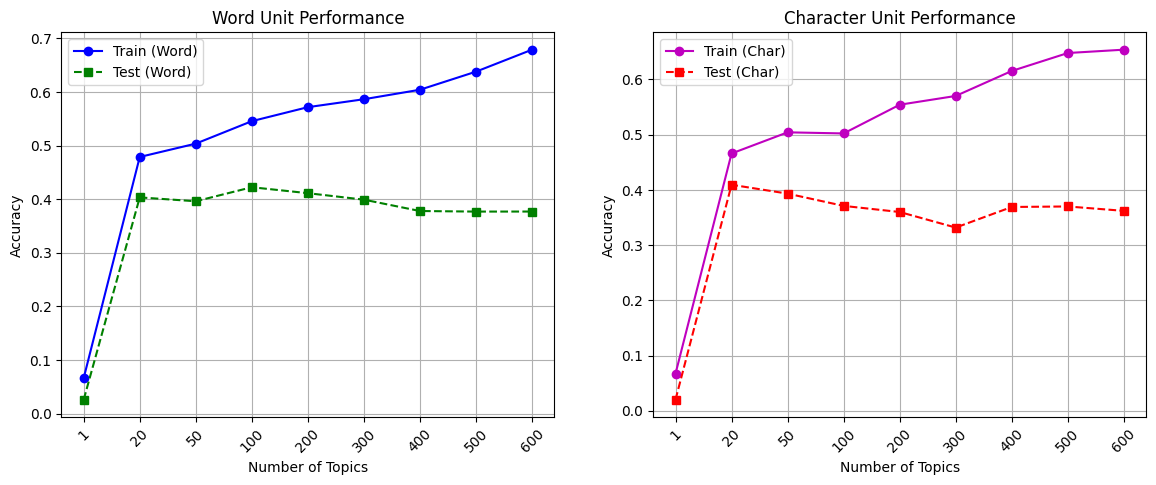

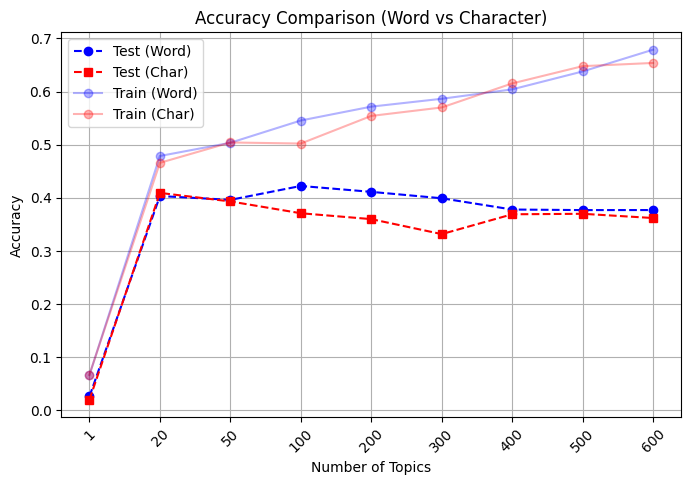

<Figure size 640x480 with 0 Axes>

In [7]:
# 原始参数定义保持不变
num_topics_lst = [1,20,50,100,200,300,400,500,600]
accuracy_train_lst = []
accuracy_test_lst = []

# 新增部分开始 -------------------------------------------------
# 创建存储字符模式结果的列表
accuracy_train_char_lst = []  # 新增字符模式训练精度列表
accuracy_test_char_lst = []

# 同时运行两种模式
for num_topics in num_topics_lst:
    # 原始词模式运行
    accuracy_train, accuracy_test = main(text_dict, paragraph_num=62, 
                                       paragraph_length=500, num_topics=num_topics,
                                       use_character=False, random_consistent=False)
    accuracy_train_lst.append(accuracy_train)
    accuracy_test_lst.append(accuracy_test)
    
    # 新增字符模式运行
    accuracy_train_char, accuracy_test_char = main(text_dict, paragraph_num=62,
                               paragraph_length=500, num_topics=num_topics,
                               use_character=True, random_consistent=False)
    accuracy_train_char_lst.append(accuracy_train_char)  # 保存字符模式训练精度
    accuracy_test_char_lst.append(accuracy_test_char)

# 可视化调整 -------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
x = num_topics_lst
new_x = np.arange(len(x))

# 原始训练/测试acc图保持不变
axes[0].plot(new_x, accuracy_train_lst, 'b-o', label='Train (Word)')
axes[0].plot(new_x, accuracy_test_lst, 'g--s', label='Test (Word)')
axes[0].set_title("Word Unit Performance")
axes[0].set_xticks(new_x)
axes[0].set_xticklabels(x, rotation=45)
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# 修改字符模式图，添加训练精度曲线
axes[1].plot(new_x, accuracy_train_char_lst, 'm-o', label='Train (Char)')  
axes[1].plot(new_x, accuracy_test_char_lst, 'r--s', label='Test (Char)')
axes[1].set_title("Character Unit Performance")
axes[1].set_xticks(new_x)
axes[1].set_xticklabels(x, rotation=45)
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# 新增对比图（可选）
plt.figure(figsize=(8, 5))
plt.plot(new_x, accuracy_test_lst, 'b--o', label='Test (Word)')
plt.plot(new_x, accuracy_test_char_lst, 'r--s', label='Test (Char)')
plt.plot(new_x, accuracy_train_lst, 'b-o', label='Train (Word)', alpha=0.3)  # 半透明显示
plt.plot(new_x, accuracy_train_char_lst, 'r-o', label='Train (Char)', alpha=0.3)  # 半透明显示
plt.xticks(new_x, x, rotation=45)
plt.title('Accuracy Comparison (Word vs Character)')
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 原始显示代码保持不变
plt.tight_layout()
plt.show()
# 新增部分结束 -------------------------------------------------

Fold 1/10 - Train Acc: 0.3993, Test Acc: 0.0938
Fold 2/10 - Train Acc: 0.3819, Test Acc: 0.0625
Fold 3/10 - Train Acc: 0.4062, Test Acc: 0.0625
Fold 4/10 - Train Acc: 0.4167, Test Acc: 0.0000
Fold 5/10 - Train Acc: 0.3993, Test Acc: 0.1250
Fold 6/10 - Train Acc: 0.3924, Test Acc: 0.0312
Fold 7/10 - Train Acc: 0.4028, Test Acc: 0.1250
Fold 8/10 - Train Acc: 0.4167, Test Acc: 0.0625
Fold 9/10 - Train Acc: 0.4167, Test Acc: 0.0312
Fold 10/10 - Train Acc: 0.4062, Test Acc: 0.0625
Average Train Accuracy: 40.38%
Average Test Accuracy: 6.56%
Fold 1/10 - Train Acc: 0.3993, Test Acc: 0.0938
Fold 2/10 - Train Acc: 0.4097, Test Acc: 0.1562
Fold 3/10 - Train Acc: 0.3924, Test Acc: 0.0312
Fold 4/10 - Train Acc: 0.4097, Test Acc: 0.0312
Fold 5/10 - Train Acc: 0.4167, Test Acc: 0.0625
Fold 6/10 - Train Acc: 0.4271, Test Acc: 0.0938
Fold 7/10 - Train Acc: 0.4201, Test Acc: 0.0938
Fold 8/10 - Train Acc: 0.4062, Test Acc: 0.0312
Fold 9/10 - Train Acc: 0.4201, Test Acc: 0.0000
Fold 10/10 - Train Acc: 0.3

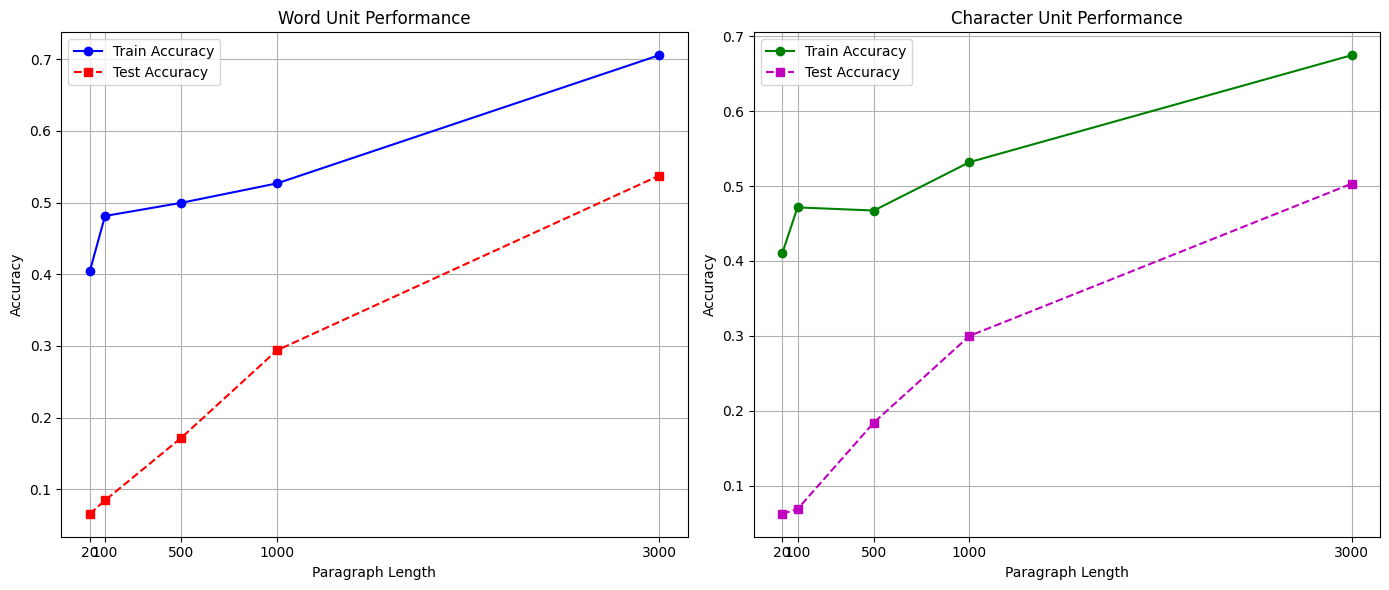

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

paragraph_length_lst = [20, 100, 500, 1000, 3000]

# 词模式结果存储
word_train_acc = []
word_test_acc = []

# 字模式结果存储
char_train_acc = []
char_test_acc = []

# 分别测试词和字模式
for paragraph_length in paragraph_length_lst:
    # 词模式测试
    train_acc, test_acc = main(text_dict, paragraph_num=20, 
                             paragraph_length=paragraph_length, 
                             num_topics=100, 
                             use_character=False, 
                             random_consistent=False)
    word_train_acc.append(train_acc)
    word_test_acc.append(test_acc)
    
    # 字模式测试
    train_acc, test_acc = main(text_dict, paragraph_num=20,
                             paragraph_length=paragraph_length,
                             num_topics=100,
                             use_character=True,
                             random_consistent=False)
    char_train_acc.append(train_acc)
    char_test_acc.append(test_acc)

# 创建画布
plt.figure(figsize=(14, 6))

# 第一张图：词模式结果
plt.subplot(1, 2, 1)
plt.plot(paragraph_length_lst, word_train_acc, 'b-o', label='Train Accuracy')
plt.plot(paragraph_length_lst, word_test_acc, 'r--s', label='Test Accuracy')
plt.title('Word Unit Performance')
plt.xlabel('Paragraph Length')
plt.ylabel('Accuracy')
plt.xticks(paragraph_length_lst)
plt.legend()
plt.grid(True)

# 第二张图：字模式结果
plt.subplot(1, 2, 2)
plt.plot(paragraph_length_lst, char_train_acc, 'g-o', label='Train Accuracy')
plt.plot(paragraph_length_lst, char_test_acc, 'm--s', label='Test Accuracy')
plt.title('Character Unit Performance')
plt.xlabel('Paragraph Length')
plt.ylabel('Accuracy')
plt.xticks(paragraph_length_lst)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
accuracy_train_character, accuracy_test_character = main(text_dict, paragraph_num=50, paragraph_length=1500, num_topics=100, use_character=True, random_consistent=False)
accuracy_train_word, accuracy_test_word = main(text_dict, paragraph_num=50, paragraph_length=1500, num_topics=100, use_character=False, random_consistent=False)

Fold 1/10 - Train Acc: 0.7806, Test Acc: 0.6250
Fold 2/10 - Train Acc: 0.7722, Test Acc: 0.6375
Fold 3/10 - Train Acc: 0.7667, Test Acc: 0.5875
Fold 4/10 - Train Acc: 0.7639, Test Acc: 0.6375
Fold 5/10 - Train Acc: 0.7097, Test Acc: 0.5750
Fold 6/10 - Train Acc: 0.7417, Test Acc: 0.7500
Fold 7/10 - Train Acc: 0.7653, Test Acc: 0.6750
Fold 8/10 - Train Acc: 0.7903, Test Acc: 0.6250
Fold 9/10 - Train Acc: 0.7514, Test Acc: 0.6250
Fold 10/10 - Train Acc: 0.7417, Test Acc: 0.6000
Average Train Accuracy: 75.83%
Average Test Accuracy: 63.37%
Fold 1/10 - Train Acc: 0.7111, Test Acc: 0.7000
Fold 2/10 - Train Acc: 0.7278, Test Acc: 0.6750
Fold 3/10 - Train Acc: 0.7694, Test Acc: 0.6375
Fold 4/10 - Train Acc: 0.7250, Test Acc: 0.7625
Fold 5/10 - Train Acc: 0.7347, Test Acc: 0.5875
Fold 6/10 - Train Acc: 0.6889, Test Acc: 0.6500
Fold 7/10 - Train Acc: 0.7597, Test Acc: 0.7000
Fold 8/10 - Train Acc: 0.7111, Test Acc: 0.7375
Fold 9/10 - Train Acc: 0.7833, Test Acc: 0.7375
Fold 10/10 - Train Acc: 0.